<h2 style="font-size:28px"><b>South Korea Total Monthly Exports Forecast (36 Months)</b></h2>

<br>
<font size="5"><b>Introduction</b></font>
<br><br>
This project aims to forecast South Korea's total monthly exports for the next 3 years. 

To acheive this, I employ **time-series modelling approaches**, focusing on two main strategies:

1. **Seasonal ARIMA (SARIMA)**: Serves as a benchmark model, explicitly capturing recurring seasonal patterns in the data.

2. **ARIMA with Manual Seasonality Adjustment**: Involves removing seasonal effects prior to model fitting and reintroducing them during forecasting, allowing for a comparison with the SARIMA approach.

By comparing these approaches, the analysis explores whether seasonality is better handled directly within the model (SARIMA) or through preprocessing (STL + ARIMA).

<br>
<font size="5"><b>Methodology</b></font>
<br><br>
<font size="4"><b>1. Data Preparation</b></font>

This project utilizes official South Korea's monthly export data from the [UK Office for National Statistics](https://www.ons.gov.uk/economy/nationalaccounts/balanceofpayments/timeseries/erdm/mret).

Key preprocessing steps include:

- **Parsing and Cleaning**: Extracted valid monthly data, converted dates to datetime format, and handled missing/non-numeric values.

- **Frequency Specification**: Ensured the time series is uniformly spaced with monthly frequency.

- **Exploratory Analysis**: Visualized the series to identify trends, seasonality, and potential outliers.
<br><br>

<font size="4"><b>2. Seasonal ARIMA (SARIMA) Modeling</b></font>

SARIMA extends ARIMA by explicitly modeling seasonal patterns, making it suitable for this monthly dataset.

**Model Structure**

SARIMA is denoted as:
$$
ARIMA(p,d,q)(P,D,Q)_m
$$
where:

- (p,d,q): Non-seasonal AR, differencing, and MA orders.

- (P,D,Q): Seasonal equivalents.

- m: Seasonal period (12 for monthly data).

**Parameter Optimization**

Used auto_arima to:

- Search over possible (p,d,q)(P,D,Q) combinations.

- Optimize for AIC (Akaike Information Criterion).

- Stepwise search for efficiency.

**Strengths**

- **Direct Seasonality Modeling**: SARIMA explicitly incorporates seasonality $(P,D,Q)m$, which is useful since exports often follow repeating economic, cultural and operational cycles.

- **Benchmark Standard**: Widely used in economic forecasting.

**Limitations**

- **Rigid Seasonality Assumption**: Assumes linear relationships and fixed seasonal patterns. This can be problematic when external shocks (eg. COVID-19, geopolitical conflicts, trade policy changes) alter trade seasonality.

- **Overfitting Risk**: With both ARIMA and seasonal terms, SARIMA model is more sensitive to noise. Long-horizon forecasts (like 3 years) may therefore accumulate errors quickly. 
<br>

<font size="4"><b>3. ARIMA with STL Decomposition</b></font>

This alternative approach applies STL decomposition (Seasonal-Trend decomposition using Loess) to seperate the series into trend, seasonality, and residuals before modeling. ARIMA is then fit to the deseasonalized series (trend + residual), and the seasonal component is reintroduced into the forecasts.

**Parameter Optimization**

- Deseasonalized data is modeled with auto_arima, selecting the best $ARIMA(p,d,q)$ order based on AIC.

- Seasonal period is fixed at 12 months in the STL step.

**Strengths**

- **Flexible Seasonality**: STL decomposition extracts seasonality adaptively, allowing the model to handle evolving seasonal structures (eg. useful for post-COVID structural changes).

- **Clear Component Seperation**: Decomposing into trend, seasonality and residuals makes interpretation easier (see graphs below), especially when assessing long-term export trend vs short-term flactuations.

**Limitations**

- **Decomposition-Sensitive Performance**: Accuracy depends heavily on the STL decomposition quality. Poor decomposition can jeopardize ARIMA's performance.

- **Manual Reconstruction**: Seasonality is not modeled within ARIMA itself; forecasts require reintroducing the seasonal component.

<br>
<font size="5"><b>Exploratory Data Analysis</b></font>
<br><br>
<font size="4"><b>Importing Libraries</b></font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

<br>
<font size="4"><b>Data Loading & Cleaning</b></font>

In [2]:
df = pd.read_csv('series-150825.csv', skiprows=7)
df.columns = ['Date', 'Exports']

df = df[df['Date'].str.contains('JAN|FEB|MAR|APR|MAY|JUN|JUL|AUG|SEP|OCT|NOV|DEC')]
df['Date'] = pd.to_datetime(df['Date'], format='%Y %b')
df.set_index('Date', inplace=True)

df['Exports'] = pd.to_numeric(df['Exports'], errors='coerce')
df = df.asfreq('MS')
series = df['Exports'].dropna()

<br>
<font size="4"><b>Initial Data Visualization</b></font>

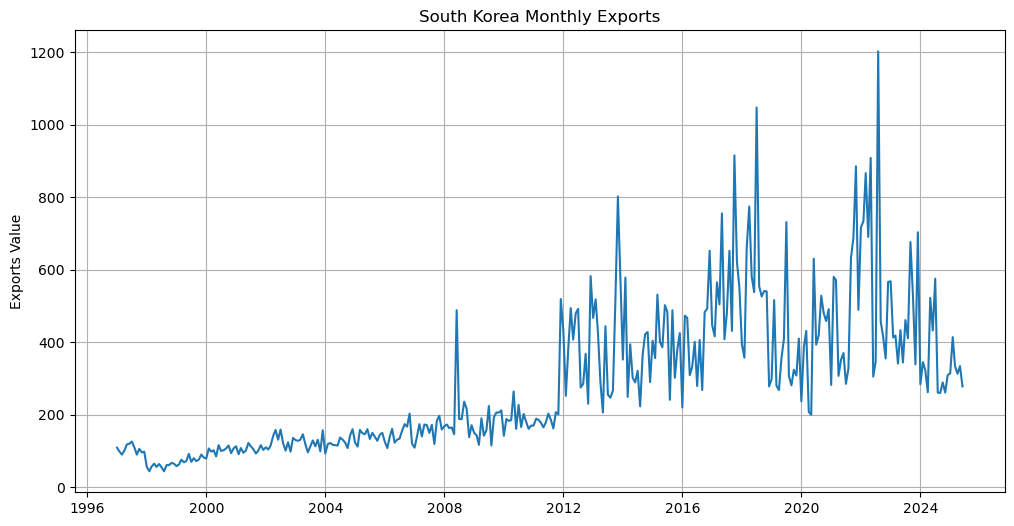

Data coverage: 1997-01-01 00:00:00 to 2025-06-01 00:00:00
Total observations: 342


In [3]:
plt.figure(figsize=(12,6))
plt.plot(series)
plt.title('South Korea Monthly Exports')
plt.ylabel('Exports Value')
plt.grid()
plt.show()

print("Data coverage:", series.index.min(), "to", series.index.max())
print("Total observations:", len(series))

<br>
<font size="5"><b>SARIMA Modeling</b></font>
<br><br>
<font size="4"><b>Automated Parameter Selection</b></font>

In [4]:
auto_sarima = pm.auto_arima(
    df['Exports'],
    seasonal=True,           
    m=12,                    
    start_p=0, start_q=0,    
    max_p=3, max_q=3,        
    d=None,                  
    D=None,                  
    start_P=0, start_Q=0,    
    max_P=2, max_Q=2,        
    trace=True,              
    error_action='ignore',   
    suppress_warnings=True,
    stepwise=True,           
    n_fits=50                
)

print("\nBest SARIMA model parameters:")
print(auto_sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4363.360, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4289.843, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4215.116, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4361.364, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=4213.868, Time=0.24 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=4215.390, Time=0.62 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=4212.894, Time=1.29 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=4206.278, Time=2.95 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=4204.979, Time=2.56 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=4350.846, Time=1.30 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=4205.987, Time=3.31 sec
 ARIMA(0,1,2)(2,0,0)[12] intercept   : AIC=4205.924, Time=2.71 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4277.853, Time=1.60 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=4199.420, Time=4.03 sec
 ARIMA(1,1,2)(1,0,0

<br>
<font size="4"><b>Fit SARIMA Model</b></font>

In [5]:
order = auto_sarima.order        
seasonal_order = auto_sarima.seasonal_order 

sarima_model = SARIMAX(
    df['Exports'],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima_model.fit(disp=False)

print("\nModel fit summary:")
print(sarima_fit.summary())


Model fit summary:
                                      SARIMAX Results                                      
Dep. Variable:                             Exports   No. Observations:                  342
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 12)   Log Likelihood               -1951.003
Date:                             Mon, 18 Aug 2025   AIC                           3914.005
Time:                                     23:30:23   BIC                           3936.540
Sample:                                 01-01-1997   HQIC                          3923.008
                                      - 06-01-2025                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8201      0.080    -10.220      0.000      -0.977      -0.663
ma.L1  

<br>
<font size="4"><b>SARIMA Forecast & Visualization</b></font>

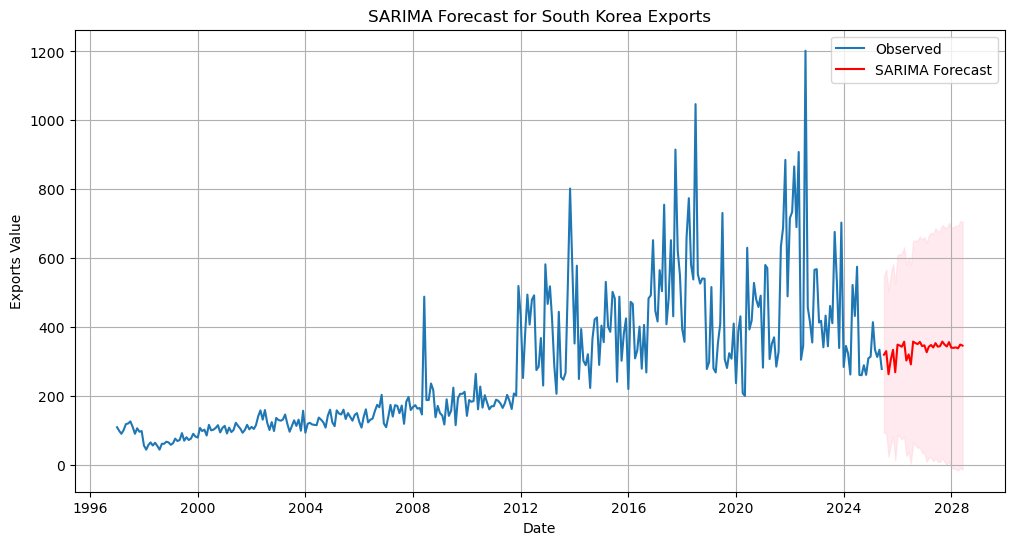

In [6]:
forecast_steps = 36
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Exports'], label='Observed')
plt.plot(forecast_mean.index, forecast_mean, color='r', label='SARIMA Forecast')
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink', alpha=0.3
)
plt.title('SARIMA Forecast for South Korea Exports')
plt.xlabel('Date')
plt.ylabel('Exports Value')
plt.legend()
plt.grid()
plt.show()

<br>
<font size="4"><b>Model Evaluation using Time Series Cross-Validation</b></font>

In [7]:
data = df['Exports'].dropna()
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []

for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    model = SARIMAX(
        train,
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    pred = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test, pred)
    mae = mean_absolute_error(test, pred)
    
    mse_scores.append(mse)
    mae_scores.append(mae)

print("\nCross-Validation Results:")
print(f"Average MSE across folds: {np.mean(mse_scores):.2f}")
print(f"Average MAE across folds: {np.mean(mae_scores):.2f}")
print(f"MSE standard deviation: {np.std(mse_scores):.2f}")
print(f"MAE standard deviation: {np.std(mae_scores):.2f}")


Cross-Validation Results:
Average MSE across folds: 24973.52
Average MAE across folds: 109.05
MSE standard deviation: 18988.97
MAE standard deviation: 58.77


<br>
<font size="4"><b>Residual Analysis (Diagnostic Plots & Ljung-Box Test)</b></font>

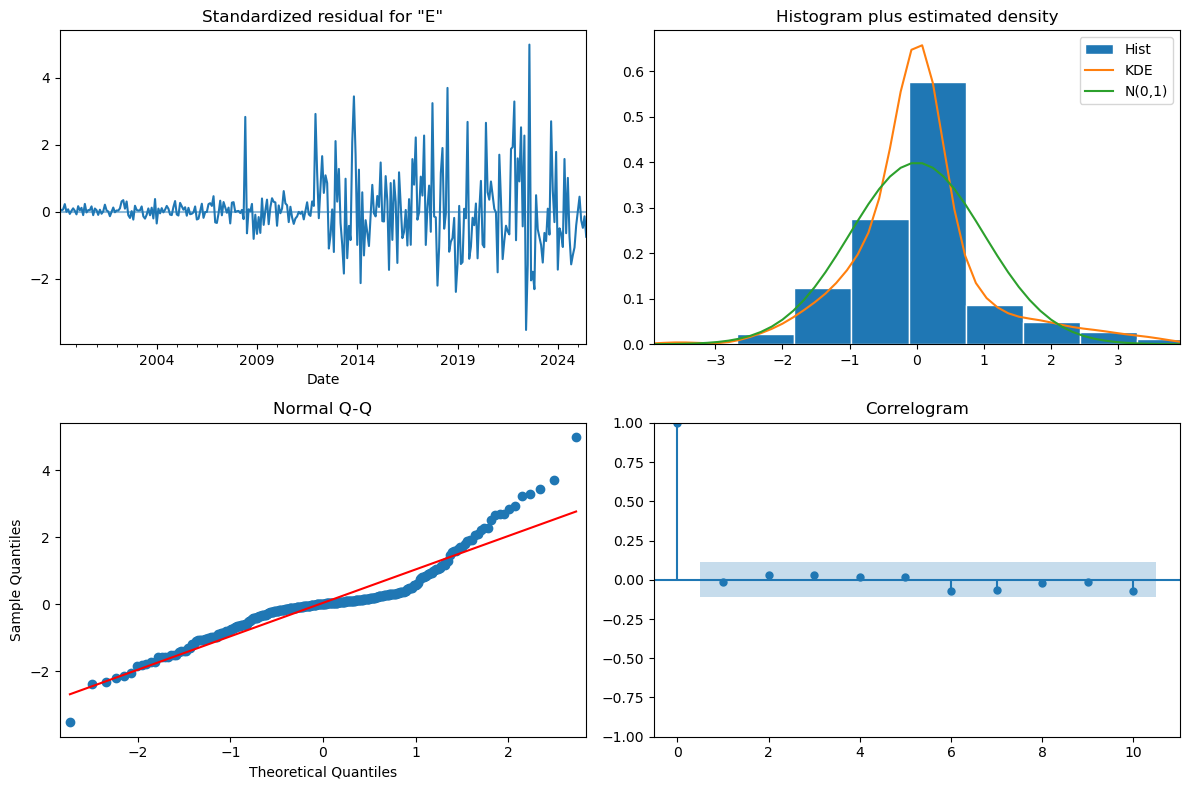


Ljung-Box test p-values:
[0.79084577 0.81254385 0.86883057 0.93788216 0.96605618 0.86258029
 0.76150366 0.82782372 0.88571253 0.79350892 0.79128638 0.84918608]


In [8]:
sarima_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(sarima_fit.resid, lags=12)
print("\nLjung-Box test p-values:")
print(lb_test.iloc[:,1].values)

<br>
<font size="5"><b>ARIMA with STL Decomposition</b></font>
<br><br>
<font size="4"><b>STL Decomposition</b></font>

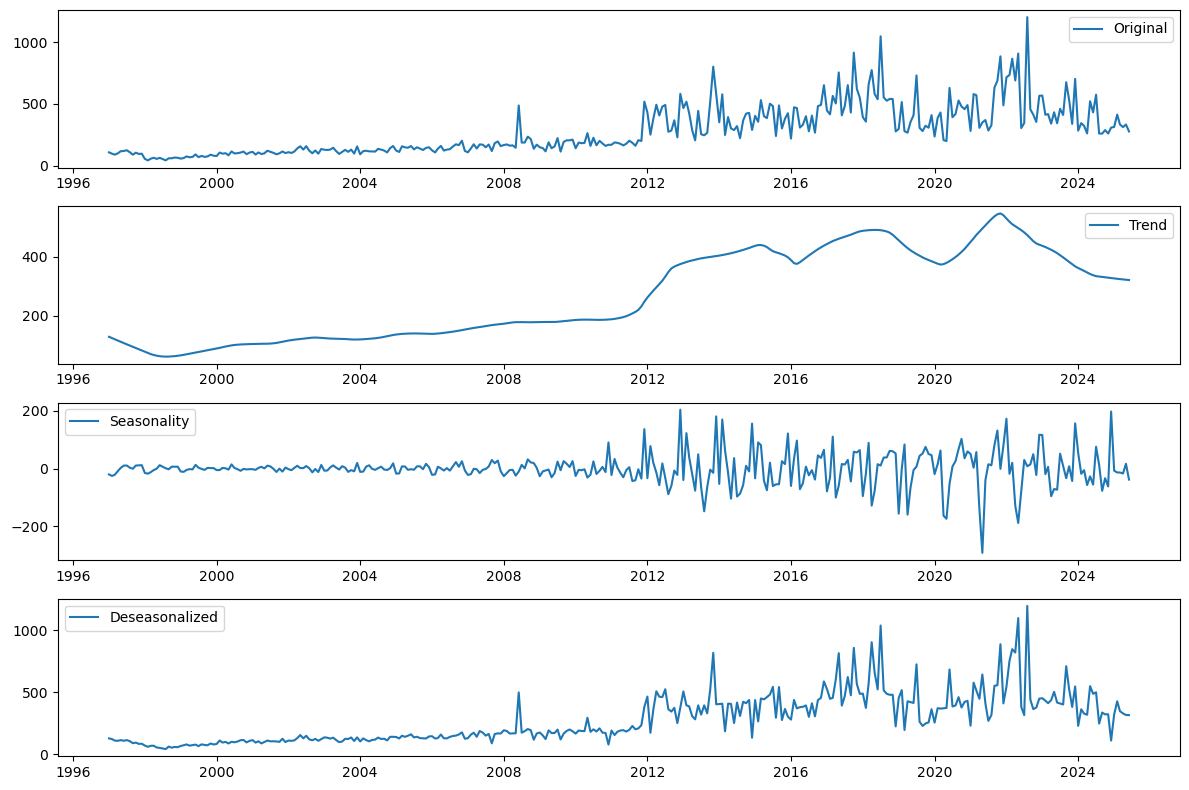

In [9]:
stl = STL(series, period=12, robust=True)
res = stl.fit()

trend = res.trend
seasonal = res.seasonal
residual = res.resid

deseasonalized = series - seasonal

plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(series, label='Original')
plt.legend()

plt.subplot(4,1,2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonality')
plt.legend()

plt.subplot(4,1,4)
plt.plot(deseasonalized, label='Deseasonalized')
plt.legend()

plt.tight_layout()
plt.show()

<br>
<font size="4"><b>Automated Parameter Selection</b></font>

In [10]:
auto_model = pm.auto_arima(
    deseasonalized,
    seasonal=False,   # already deseasonalized with STL
    stepwise=True,
    suppress_warnings=True,
    trace=True,
    error_action="ignore"
)

print("Best ARIMA model found by pmdarima (full series):", auto_model.order)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4201.828, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4358.602, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4284.544, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4203.386, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4356.607, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4202.036, Time=0.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4205.068, Time=0.46 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4199.981, Time=0.97 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4199.042, Time=0.66 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4218.792, Time=0.13 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4199.693, Time=0.93 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4219.759, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=4208.712, Time=0.49 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4201.591, Time=1.34 sec
 ARIMA(3,1,1)(0,0,0)[0]          

<br>
<font size="4"><b>ARIMA Forecasting & Visualization</b></font>

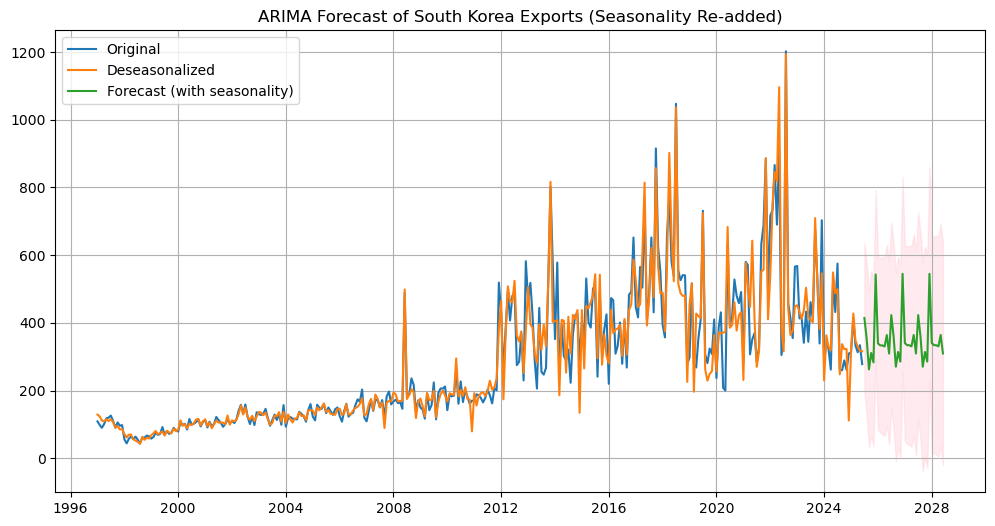

In [11]:
model = ARIMA(deseasonalized, order=auto_model.order)
model_fit = model.fit()

forecast = model_fit.get_forecast(steps=36)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

future_seasonality = seasonal[-12:].tolist() * 3  # repeat last year’s seasonality
forecast_with_seasonality = forecast_mean + future_seasonality[:36]

plt.figure(figsize=(12,6))
plt.plot(series.index, series, label='Original')
plt.plot(deseasonalized.index, deseasonalized, label='Deseasonalized')
plt.plot(forecast_mean.index, forecast_with_seasonality, label='Forecast (with seasonality)')
plt.fill_between(
    forecast_mean.index,
    forecast_ci.iloc[:,0] + future_seasonality[:36],
    forecast_ci.iloc[:,1] + future_seasonality[:36],
    color='pink', alpha=0.3
)

plt.title("ARIMA Forecast of South Korea Exports (Seasonality Re-added)")
plt.legend()
plt.grid()
plt.show()

<br>
<font size="4"><b>Model Evaluation using Time Series Cross-Validation</b></font>

In [12]:
data = deseasonalized.dropna()
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
mae_scores = []

for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    model = ARIMA(train, order=(1,1,1))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test, pred)
    mae = mean_absolute_error(test, pred)
    mse_scores.append(mse)
    mae_scores.append(mae)

print("\nCross-Validation Results:")
print(f"Average MSE across folds: {np.mean(mse_scores):.2f}")
print(f"Average MAE across folds: {np.mean(mae_scores):.2f}")
print(f"MSE standard deviation: {np.std(mse_scores):.2f}")
print(f"MAE standard deviation: {np.std(mae_scores):.2f}")


Cross-Validation Results:
Average MSE across folds: 27000.35
Average MAE across folds: 106.04
MSE standard deviation: 20573.13
MAE standard deviation: 62.38


<br>
<font size="4"><b>Residual Analysis (Diagnostic Plots & Ljung-Box Test)</b></font>

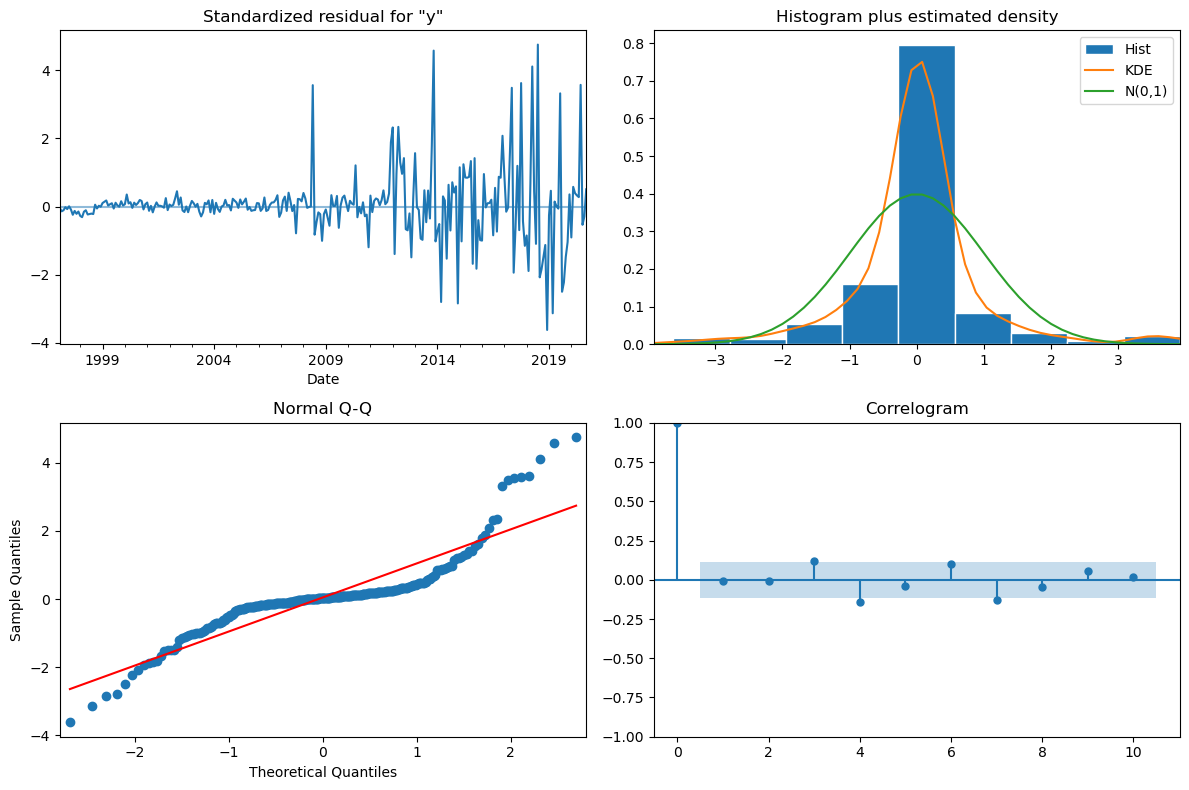


Ljung-Box test p-values:
[0.92894583 0.9868714  0.24312075 0.04012109 0.06245742 0.03911722
 0.01207281 0.01673516 0.021269   0.0331795  0.01856372 0.02415592]


In [13]:
model_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

lb_test = acorr_ljungbox(model_fit.resid, lags=12)
print("\nLjung-Box test p-values:")
print(lb_test.iloc[:, 1].values)

<br>
<font size="5"><b>Key Takeaways</b></font>
<br><br> 

**a) Exploratory Data Analysis (EDA)**

- **Trend Analysis:**

  * The series shows a long-term upward trend, especially from around 2010 onwards.

  * The trend line confirms a gradual increase from 1996 to 2010, followed by more rapid growth from 2010 to 2020.
 
  * After 2020, the trend peaks and slightly declines, suggesting a slowdown or recent decrease in exports.

- **Seasonality Analysis:**

  * **Pre-2010:** Minimal seasonal fluctuations.

  * **Post-2010:** Pronounced and volatile seasonal patterns, indicating increasing seasonal effects in exports.

- **Anomalies:**

  * Extreme negative spikes are visible around 2020–2022, which may correspond to exceptional events (eg. COVID-19 impact).

<br>

**b) Cross-Validation Results**

- **SARIMA** performs slightly better in terms of MSE (24,973 vs 27,000) but marginally worse in MAE (109.05 vs  106.04).

  * Lower MSE suggests SARIMA’s forecasts are closer to actual values on average (since MSE penalizes large errors more severely).

  * Slightly higher MAE indicates that, on average, SARIMA’s absolute errors are a tiny bit worse than ARIMA+STL.

- **SARIMA** has lower standard deviations in both MSE (18,988 vs. 20,573) and MAE (58.77 vs. 62.38).

  * This means SARIMA’s performance is more consistent across different time periods (less variance in errors).
  
  * ARIMA+STL has higher variability, meaning it sometimes performs much worse (likely due to imperfect deseasonalization).

<br>

**c) Residual Analysis**

- **SARIMA -** All p-values > 0.05 (all > 0.7), which means that:

   * SARIMA successfully modeled both trend and seasonality, leaving clean residuals.
   
   * The residuals behave like white noise, meaning the model captured most patterns.
 
- **ARIMA+STL -** High p-values for first 3 lags but multiple p-values < 0.05 (eg. 0.040, 0.039, 0.012, etc.), which means that:

   * The deseasonalization process (STL) did not fully remove all temporal dependencies.
 
   * ARIMA alone could not capture all remaining patterns, leading to missed autocorrelations.

<br>
<font size="5"><b>Conclusion</b></font>
<br><br>

The **SARIMA model** outperformed the **ARIMA+STL Decomposition** approach for this dataset, highlighting the importance of explicitly modeling seasonality in exports data. 

To further enhance forecast accuracy, a **hybrid model** combining **SARIMA/ARIMA with machine learning** could be explored. Examples include:

- **ARIMA-LSTM** ([Dave et al., 2021](https://doi.org/10.1016/j.procs.2021.01.031))

- **SARIMA-XGBoost** ([Man et al., 2023](https://doi.org/10.1017/S0950268823001905))

Such hybrid models can leverage SARIMA/ARIMA to capture trend and seasonal patterns, while machine learning models address remaining nonlinearities in the residuals, potentially improving both MSE and MAE.